## Project Goal

The objective of this project is to **reproduce the results of the IVON paper**  
([Shen et al., 2024](https://proceedings.mlr.press/v235/shen24b.html)).  
IVON presents a refined and elegant synthesis of several influential prior works in adaptive Bayesian optimization and natural gradient methods, including:

- [**Khan et al.**](https://dl.acm.org/doi/abs/10.5555/3648699.3648980)  
- [**Khan & Rue**](https://proceedings.mlr.press/v80/khan18a.html)  
- [**Lin et al.**](https://proceedings.mlr.press/v119/lin20d.html)  
- [**Zhang et al.**](https://dl.acm.org/doi/10.5555/3454287.3454673)

This project aims to carefully reconstruct the experimental setup, methodology, and quantitative findings presented in the paper to ensure a faithful replication.

For deeper context, motivations, and additional explanations, consult:

- https://ysngshn.github.io/research/why-ivon/  
- https://adaptive-bayesian.ai/blog/ivon/
- https://github.com/team-approx-bayes/ivon-experiments


In [1]:
# !pip install torch --index-url https://download.pytorch.org/whl/cu118
!pip install ivon-opt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import ivon
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import sys
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:

print("Python version:")
print(sys.version)

print("\nPyTorch version:")
print(torch.__version__)

Python version:
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

PyTorch version:
2.9.0+cu126


## Loading, Splitting, and Preparing the CIFAR-10 Dataset

This section loads the CIFAR-10 dataset and applies standard preprocessing used in many deep-learning experiments. CIFAR-10 contains 60,000 color images at 32×32 resolution across 10 classes. For more information, see the official dataset page: [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html). We use the standard CIFAR-10 channel-wise mean and standard deviation `(0.4914, 0.4822, 0.4465)` and `(0.2470, 0.2435, 0.2616)` to normalize images, which helps stabilize training by making pixel values more consistent. The dataset is loaded using the `torchvision.datasets.CIFAR10` class documented at: [torchvision CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html).

The code below first defines the normalization values, then creates two transform pipelines: a training transform that includes random cropping and horizontal flipping for data augmentation, and a testing transform that applies only tensor conversion and normalization. The training portion of the CIFAR-10 dataset is then loaded twice so we can construct a train/validation split: one version uses the augmented transforms for training, and the other uses the non-augmented transforms for validation. After splitting the dataset into training and validation subsets, we load the test set with only normalization. Finally, we wrap the train, validation, and test datasets in PyTorch `DataLoader` objects with a batch size of 50.

This procedure matches the dataset handling strategy used in the [IVON reference implementation](https://github.com/team-approx-bayes/ivon-experiments/blob/main/common/dataloaders.py).

In [5]:
# --- Standard CIFAR-10 normalization ---
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- Load CIFAR-10 train data (will later be split into train and val) ---
full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform_train,   # training transform (with augmentation)
    download=True
)

# --- Create a validation dataset that uses NO augmentation ---
full_val_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform_test,    # no augmentation for validation
    download=True
)

# --- Train/Val split ---
train_ratio = 0.9          # e.g., 90% train, 10% validation
n_train = int(len(full_train_dataset) * train_ratio)
n_val = len(full_train_dataset) - n_train

train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible split
)

# Replace validation transform
val_dataset.dataset = full_val_dataset

# --- Load CIFAR-10 test data ---
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform_test,
    download=True
)

# --- DataLoaders (batch_size = 50 to match IVON paper) ---
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=50, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=50, shuffle=False)


100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s]


## ResNet-20 Implementation

The following code block implements **ResNet-20 exactly as described in the original paper**  
[**Deep Residual Learning for Image Recognition**](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7780459)

Important clarifications:

- The **original authors did not release their CIFAR-ResNet20 implementation in PyTorch**  
  (their official codebase was in [**Caffe**](https://github.com/KaimingHe/deep-residual-networks)).
- The **IVON paper** uses “the standard CIFAR-10 20-layer ResNet” from the original work,  
  but does **not** include its own ResNet20 implementation in the repository.
- Therefore, our implementation follows the **canonical and widely-used PyTorch version**:  
  https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py  
  which is a faithful reproduction of the architecture in the main ResNet paper.

This ensures that our model architecture is **fully aligned** with both the **original ResNet-20 design** and the **model used in IVON experiments**.


In [6]:

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet20(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(16, 3, stride=1)
        self.layer2 = self._make_layer(32, 3, stride=2)
        self.layer3 = self._make_layer(64, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, planes, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc(out)


# Unified Evaluation & Calibration Metrics

This section provides helper functions for evaluating classification models trained with both **deterministic optimizers** (SGD, AdamW) and **posterior‐sampling optimizers** such as **IVON**.  
The evaluation includes both **accuracy metrics** and **uncertainty metrics**, providing a complete understanding of model behavior.

---

## 1. `evaluate_probs()` — Probability Extraction & Posterior Sampling

This function computes model probabilities under different inference regimes:

### **A. Deterministic Models (SGD, AdamW)**  
Uses fixed model parameters:

$$
p_i = \operatorname{softmax}(f_\theta(x_i))
$$

### **B. IVON@mean (`test_samples = 0`)**  
Uses the **posterior mean** \( m \) as the model parameters:

$$
\theta = m
$$

### **C. IVON Posterior Sampling (`test_samples ≥ 1`)**

- `test_samples = 1` → one posterior sample  
- `test_samples > 1` → Monte Carlo posterior averaging:

$$
\bar{p}_i =
\frac{1}{T}
\sum_{t=1}^{T}
\operatorname{softmax}(f_{\theta^{(t)}}(x_i))
$$

The function returns:
- Predicted probabilities  
- Ground‐truth labels  
- Logits (needed for NLL)

---

## 2. `plot_calibration_curve()` — Reliability Diagram

A reliability diagram visualizes how predicted confidence aligns with empirical accuracy.

For each sample \( i \):

- Confidence:
  $$
  c_i = \max_k p_{ik}
  $$

- Predicted class:
  $$
  \hat{y}_i = \arg\max_k p_{ik}
  $$

- Correctness:
  $$
  \text{correct}_i =
  \begin{cases}
  1, & \hat{y}_i = y_i \\
  0, & \text{otherwise}
  \end{cases}
  $$

Samples are binned by confidence, and for each bin \( B_m \):

$$
\text{acc}(B_m)
=
\frac{1}{|B_m|}
\sum_{i \in B_m}
\mathbf{1}[\hat{y}_i = y_i]
$$

$$
\text{conf}(B_m)
=
\frac{1}{|B_m|}
\sum_{i \in B_m}
c_i
$$

A perfectly calibrated model lies on the diagonal \( y = x \).

---

## 3. `compute_ece()` — Expected Calibration Error (ECE)

ECE quantifies the misalignment between confidence and accuracy:

$$
\text{ECE}
=
\sum_{m=1}^{M}
\frac{|B_m|}{N}
\,
\left|
\text{acc}(B_m)
-
\text{conf}(B_m)
\right|
$$

Lower ECE means better calibration.

---

## 4. `evaluate_all_metrics()` — Comprehensive Evaluation

This function computes both accuracy and uncertainty metrics.

### **Top-1 Accuracy**
$$
\text{Acc@1}
=
\frac{1}{N}
\sum_{i=1}^{N}
\mathbf{1}[\hat{y}_i = y_i]
$$

### **Top-5 Accuracy**
$$
\text{Acc@5}
=
\frac{1}{N}
\sum_{i=1}^{N}
\mathbf{1}[y_i \in \text{Top5}(p_i)]
$$

### **Negative Log-Likelihood (NLL)**
$$
\text{NLL}
=
-\frac{1}{N}
\sum_{i=1}^{N}
\log p_{i, y_i}
$$

### **Expected Calibration Error (ECE)**  
(as defined above)

### **Brier Score**
$$
\text{Brier}
=
\frac{1}{N}
\sum_{i=1}^{N}
\sum_{k=1}^{K}
\left(p_{ik} - \mathbf{1}[y_i = k]\right)^2
$$

The function returns all metrics plus raw probabilities and labels.

---

## 5. `compare_methods()` — Evaluate Multiple Training Methods

This utility evaluates several optimizers under a shared protocol.

### **Input format**
```python
methods_dict = {
    "SGD":       (model_sgd, optimizer_sgd, 0),
    "AdamW":     (model_adam, optimizer_adam, 0),
    "IVON@mean": (model_ivon, optimizer_ivon, 0),
    "IVON-MC8":  (model_ivon, optimizer_ivon, 8)
}


In [7]:
def evaluate_probs(model, optimizer, loader, device, test_samples=0):
    """
    test_samples = 0 → IVON@mean        (deterministic mean weights)
    test_samples = 1 → single posterior sample
    test_samples > 1 → MC posterior averaging
    Deterministic optimizers automatically handled.
    """

    model.eval()
    all_probs, all_labels, all_logits = [], [], []
    ivon_mode = hasattr(optimizer, "sampled_params")

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            # ================================================
            # CASE A — IVON@mean (deterministic)
            # ================================================
            if ivon_mode and test_samples == 0:
                logits = model(X)
                probs = F.softmax(logits, dim=1)

            # ================================================
            # CASE B — IVON with posterior sampling
            # ================================================
            elif ivon_mode and test_samples >= 1:

                if test_samples == 1:
                    # single posterior sample
                    with optimizer.sampled_params(train=False):
                        logits = model(X)
                        probs = F.softmax(logits, dim=1)

                else:
                    # MC averaging
                    num_classes = model.fc.out_features if hasattr(model, "fc") else 10
                    mc_probs = torch.zeros(test_samples, X.size(0), num_classes, device=device)

                    for s in range(test_samples):
                        with optimizer.sampled_params(train=False):
                            mc_probs[s] = F.softmax(model(X), dim=1)

                    probs = mc_probs.mean(0)
                    logits = probs.log()  # logits not meaningful under MC, but needed for uniform API

            # ================================================
            # CASE C — Deterministic optimizers (SGD/AdamW/etc.)
            # ================================================
            else:
                logits = model(X)
                probs = F.softmax(logits, dim=1)

            all_probs.append(probs.cpu())
            all_logits.append(logits.cpu())
            all_labels.append(y.cpu())

    return torch.cat(all_probs), torch.cat(all_labels), torch.cat(all_logits)



# =======================================================================

def compute_ece(probs, labels, n_bins=15):
    confidences, preds = probs.max(dim=1)
    correctness = preds.eq(labels)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)

    ece = 0.0
    for i in range(n_bins):
        low, high = bin_boundaries[i], bin_boundaries[i+1]
        mask = (confidences >= low) & (confidences < high)
        if not mask.any():
            continue

        bin_conf = confidences[mask].mean()
        bin_acc = correctness[mask].float().mean()
        ece += mask.float().mean() * (bin_conf - bin_acc).abs()

    return float(ece)

# =======================================================================

def evaluate_all_metrics(model, optimizer, loader, device, test_samples=0):
    model.eval()

    probs, labels, logits = evaluate_probs(
        model, optimizer, loader, device, test_samples
    )

    # Top-1 accuracy
    top1 = (probs.argmax(1) == labels).float().mean().item()

    # Top-5 accuracy (safe for CIFAR-10 & larger datasets)
    top5 = (
        probs.topk(min(5, probs.size(1)), dim=1).indices
        .eq(labels.unsqueeze(1))
        .any(dim=1)
        .float()
        .mean()
        .item()
    )

    # True NLL (cross-entropy)
    nll = F.cross_entropy(logits, labels, reduction="mean").item()

    # ECE
    ece = compute_ece(probs, labels)

    # Brier score
    one_hot = F.one_hot(labels, probs.size(1)).float()
    brier = ((probs - one_hot) ** 2).mean().item()

    return {
        "Top-1 Acc ↑": top1,
        "Top-5 Acc ↑": top5,
        "NLL ↓": nll,
        "ECE ↓": ece,
        "Brier ↓": brier,
        "probs": probs,
        "labels": labels,
    }
#=========================================================================
def compare_methods(methods_dict, loader, device):
    """
    methods_dict example:
    {
        "IVON@mean": (model_ivon, optimizer_ivon, 0),
        "IVON-MC8":  (model_ivon, optimizer_ivon, 8),
        "SGD":       (model_sgd, optimizer_sgd, 0)
    }
    """

    rows = []

    for name, (model, optimizer, samples) in methods_dict.items():
        print(f"Evaluating {name} (samples={samples})...")

        metrics = evaluate_all_metrics(
            model=model,
            optimizer=optimizer,
            loader=loader,
            device=device,
            test_samples=samples
        )

        rows.append({
            "Method": name,
            "Top-1 Acc ↑": metrics["Top-1 Acc ↑"],
            "Top-5 Acc ↑": metrics["Top-5 Acc ↑"],
            "NLL ↓": metrics["NLL ↓"],
            "ECE ↓": metrics["ECE ↓"],
            "Brier ↓": metrics["Brier ↓"],
        })

    df = pd.DataFrame(rows).set_index("Method")
    print("\n=== Comparison Table ===")
    print(df)
    return df
#====================================================================

def plot_calibration_curve(probs, labels, n_bins=15, label_name="Model"):
    """
    Plots a reliability diagram (calibration curve) for a model.

    probs: tensor (N, C) with predicted probabilities
    labels: tensor (N,)
    """

    # Convert to numpy
    probs_np = probs.numpy()
    labels_np = labels.numpy()

    # Predicted confidence = max probability per sample
    confidences = np.max(probs_np, axis=1)

    # Predicted class
    predictions = np.argmax(probs_np, axis=1)

    # Correctness mask
    correctness = (predictions == labels_np).astype(int)

    # Compute calibration curve (fraction of positives vs confidence)
    frac_pos, mean_conf = calibration_curve(
        correctness,
        confidences,
        n_bins=n_bins,
        strategy='uniform'
    )

    # Plot
    plt.plot(mean_conf, frac_pos, marker="o", label=label_name)
    plt.plot([0, 1], [0, 1], "--", color="gray")  # perfect calibration
    plt.xlabel("Mean predicted confidence")
    plt.ylabel("Fraction of correct predictions")
    plt.title("Calibration Curve (Reliability Diagram)")
    plt.grid(True)


In [ ]:
# --- Train IVON ---
model_ivon = ResNet20().to(device)

optimizer_ivon = ivon.IVON(model_ivon.parameters(), lr=0.1, ess=len(train_dataset))

train_samples = 1

for epoch in range(150):
    model_ivon.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer_ivon.zero_grad()

        for _ in range(train_samples):
            with optimizer_ivon.sampled_params(train=True):
                logits = model_ivon(X)
                loss = F.cross_entropy(logits, y)
                loss.backward()

        optimizer_ivon.step()

    print(f"IVON Epoch done: {epoch+1}")


##################################################################################
def train_sgd(model, optimizer, train_loader, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

        print(f"SGD Epoch done: {epoch+1}")


model_sgd = ResNet20().to(device)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.1)


train_sgd(model_sgd, optimizer_sgd, train_loader, device=device, epochs=150)
##################################################################################
def train_adam(model, optimizer, train_loader, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()  # MUST be inside the loop

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

        print(f"Adam Epoch {epoch+1} done")


model_adam = ResNet20().to(device)
# optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

optimizer_adam = torch.optim.AdamW(
    model_adam.parameters(),
    lr=1e-3,
    weight_decay=5e-4,
    betas=(0.9, 0.999)
)


train_adam(model_adam, optimizer_adam, train_loader, device, epochs=150)

##################################################################################
import torch

# ===== Save IVON =====
torch.save({
    "model_state_dict": model_ivon.state_dict(),
    "optimizer_state_dict": optimizer_ivon.state_dict(),
}, f"{save_dir}/ivon_checkpoint.pth")
print("Saved IVON checkpoint!")

# ===== Save SGD =====
torch.save({
    "model_state_dict": model_sgd.state_dict(),
    "optimizer_state_dict": optimizer_sgd.state_dict(),
}, f"{save_dir}/sgd_checkpoint.pth")
print("Saved SGD checkpoint!")

# ===== Save AdamW =====
torch.save({
    "model_state_dict": model_adam.state_dict(),
    "optimizer_state_dict": optimizer_adam.state_dict(),
}, f"{save_dir}/adam_checkpoint.pth")
print("Saved Adam checkpoint!")


In [ ]:
# ===========================================
# 1. Mount Google Drive
# ===========================================
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# ===========================================
# 2. Define save directory
# ===========================================
save_dir = "/content/drive/MyDrive/Colab Notebooks/ADL/ivon-main"

# Optional: list contents
import os
print("Files in save_dir:", os.listdir(save_dir))

# ===========================================
# 3. Rebuild model architecture
# Make sure ResNet20() is already defined in your notebook.
# ===========================================
model_ivon = ResNet20().to(device)
model_sgd = ResNet20().to(device)
model_adam = ResNet20().to(device)

# ===========================================
# 4. Rebuild optimizers exactly as during training
# ===========================================
# IVON optimizer
optimizer_ivon = ivon.IVON(
    model_ivon.parameters(),
    lr=0.1,
    ess=len(train_dataset)
)

# SGD optimizer
optimizer_sgd = torch.optim.SGD(
    model_sgd.parameters(),
    lr=0.1
)

# AdamW optimizer
optimizer_adam = torch.optim.AdamW(
    model_adam.parameters(),
    lr=1e-3,
    weight_decay=5e-4,
    betas=(0.9, 0.999)
)

# ===========================================
# 5. Load checkpoints
# ===========================================
# ----- IVON -----
ckpt = torch.load(f"{save_dir}/ivon_checkpoint.pth", map_location=device)
model_ivon.load_state_dict(ckpt["model_state_dict"])
optimizer_ivon.load_state_dict(ckpt["optimizer_state_dict"])
print("Loaded IVON checkpoint")

# ----- SGD -----
ckpt = torch.load(f"{save_dir}/sgd_checkpoint.pth", map_location=device)
model_sgd.load_state_dict(ckpt["model_state_dict"])
optimizer_sgd.load_state_dict(ckpt["optimizer_state_dict"])
print("Loaded SGD checkpoint")

# ----- AdamW -----
ckpt = torch.load(f"{save_dir}/adam_checkpoint.pth", map_location=device)
model_adam.load_state_dict(ckpt["model_state_dict"])
optimizer_adam.load_state_dict(ckpt["optimizer_state_dict"])
print("Loaded AdamW checkpoint")

print("\n=== All models successfully loaded! ===")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Files in save_dir: ['.gitignore', 'setup.py', 'LICENSE', 'ivon', 'logistic.ipynb', 'ivon_excluded_model.pth', 'sgd_excluded_model.pth', 'IVONrep.ipynb', 'ivon_checkpoint.pth', 'sgd_checkpoint.pth', 'adam_checkpoint.pth', 'MAP_vs_IVON', 'ID&OOD_uncertainty_eval2.ipynb', 'ID&OOD_uncertainty_eval.ipynb']
Loaded IVON checkpoint
Loaded SGD checkpoint
Loaded AdamW checkpoint

=== All models successfully loaded! ===



Running unified evaluation...

Evaluating SGD (samples=0)...
Evaluating Adam (samples=0)...
Evaluating IVON@mean (samples=0)...
Evaluating IVON-MC8 (samples=8)...

=== Comparison Table ===
           Top-1 Acc ↑  Top-5 Acc ↑     NLL ↓     ECE ↓   Brier ↓
Method                                                           
SGD             0.8879       0.9965  0.545972  0.075087  0.018366
Adam            0.8910       0.9952  0.545253  0.070578  0.018109
IVON@mean       0.8704       0.9949  0.431731  0.048895  0.019432
IVON-MC8        0.8706       0.9952  0.421850  0.040627  0.019306
Plotting calibration curve for SGD ...
Plotting calibration curve for Adam ...
Plotting calibration curve for IVON@mean ...
Plotting calibration curve for IVON-MC8 ...


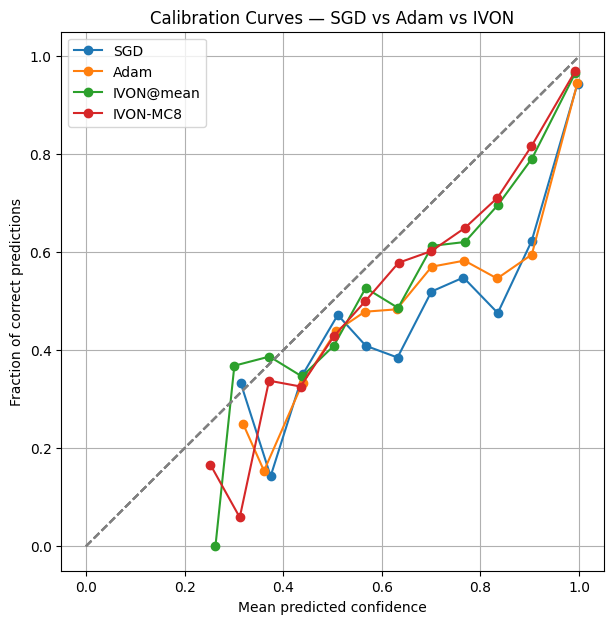


Final Comparison Table:


,Top-1 Acc ↑,Top-5 Acc ↑,NLL ↓,ECE ↓,Brier ↓
Method,,,,,
SGD,0.8879,0.9965,0.545972,0.075087,0.018366
Adam,0.8910,0.9952,0.545253,0.070578,0.018109
IVON@mean,0.8704,0.9949,0.431731,0.048895,0.019432
IVON-MC8,0.8706,0.9952,0.421850,0.040627,0.019306


In [ ]:
# --- Unified evaluation: SGD vs Adam vs IVON@mean vs IVON posterior-average ---

print("\nRunning unified evaluation...\n")

methods = {
    "SGD":        (model_sgd,  optimizer_sgd,      0),   # deterministic
    "Adam":       (model_adam, optimizer_adam,     0),   # deterministic
    "IVON@mean":  (model_ivon, optimizer_ivon,     0),   # ZERO sampling → mean weights
    "IVON-MC8":   (model_ivon, optimizer_ivon,     8),   # 8 posterior samples
}

df_results = compare_methods(methods, test_loader, device)

# --- Plot calibration curves ---
plt.figure(figsize=(7,7))

for name, (model_m, optim_m, test_samples) in methods.items():
    print(f"Plotting calibration curve for {name} ...")
    probs, labels, _ = evaluate_probs(model_m, optim_m, test_loader, device, test_samples)
    plot_calibration_curve(probs, labels, n_bins=15, label_name=name)

plt.title("Calibration Curves — SGD vs Adam vs IVON")
plt.legend()
plt.grid(True)
plt.show()

# --- Show results table again clearly ---
print("\nFinal Comparison Table:")
display(df_results)


## Understanding `train_samples` and `test_samples` in IVON

Having understood the implementation details in the previous cells of the notebook, we now turn to clarify the conceptual distinction between the two sampling parameters, **`train_samples`** and **`test_samples`**, which appear in the code. Both originate from the same variational Bayesian principle but play distinct roles in the learning and inference stages. During training, the optimizer minimizes

$$
{L}(q) = \lambda\, \mathbb{E}_{q_{\eta}(\theta)}[\bar{\ell}(\theta)] + D_{\mathrm{KL}}(q_{\eta}(\theta)\,\|\,p(\theta)),
$$  

where $q_{\eta}(\theta)$ is the approximate posterior over network weights. Because the expectation over $q_{\eta}(\theta)$ is intractable, it is replaced by a Monte Carlo estimate obtained through a finite number of **train-time samples**:  

$$
\nabla_{\eta}{L}(q) \approx \frac{1}{S_{\text{train}}} \sum_{s=1}^{S_{\text{train}}} \nabla_{\eta}\ell(\theta^{(s)}),
\quad \theta^{(s)} \sim q_{\eta}(\theta).
$$  

Each sampled parameter vector $\theta^{(s)}$ represents a stochastic realization of the model’s weights used to compute the loss gradient, thereby injecting uncertainty directly into the optimization process. The parameter `train_samples` thus determines how many such draws are taken per minibatch, balancing computational cost against the variance of the gradient estimate.

At evaluation time, the same variational posterior $q_{\eta}(\theta)$ is employed to form predictions that integrate over parameter uncertainty. Since the predictive distribution  

$$
p(y \mid x) = \int p(y \mid x, \theta)\, q_{\eta}(\theta)\, d\theta
$$  

is also analytically intractable, it is approximated via Monte Carlo averaging over **test-time samples**:  

$$
p(y \mid x) \approx \frac{1}{S_{\text{test}}} \sum_{s=1}^{S_{\text{test}}} p(y \mid x, \theta^{(s)}),
\quad \theta^{(s)} \sim q_{\eta}(\theta).
$$  

Here, `test_samples` specifies the number of posterior weight realizations used to average predictions, determining the accuracy of the Bayesian model average approximation. Increasing `test_samples` improves calibration and negative log-likelihood but incurs greater inference cost. As demonstrated in the subsequent code reproducing **Figure 4** of the original paper, varying these two sampling parameters—during both training and testing—reveals their complementary influence on model accuracy and uncertainty, illustrating how IVON leverages stochasticity across both phases to achieve well-calibrated predictive performance.


In [10]:
# ==============================================================
# Reproduce Figure 4 from the IVON paper:
# Effect of Monte Carlo samples during inference
# and training on Accuracy and NLL.
# ==============================================================

# --------------------------------------------------------------
# 1. Train IVON with different train_samples values
# --------------------------------------------------------------
def train_ivon(train_samples=1, epochs=150):
    model = ResNet20().to(device)
    optimizer = ivon.IVON(model.parameters(), lr=0.1, ess=len(train_dataset))

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            for _ in range(train_samples):
                with optimizer.sampled_params(train=True):
                    logits = model(X)
                    loss = F.cross_entropy(logits, y)
                    loss.backward()
            optimizer.step()
    return model, optimizer


# --------------------------------------------------------------
# 2. Evaluate Accuracy and NLL for different test_samples values
# --------------------------------------------------------------
def evaluate_metric_sweep(model, optimizer, test_loader, test_samples_list):
    accs, nlls = [], []

    ivon_mode = hasattr(optimizer, "sampled_params")

    for t in test_samples_list:

        # --- IMPORTANT ---
        # Only IVON supports test_samples > 0
        # SGD / AdamW MUST always use test_samples = 0
        if not ivon_mode:
            t = 0  # force deterministic behavior

        metrics = evaluate_all_metrics(model, optimizer, test_loader, device, test_samples=t)
        accs.append(metrics["Top-1 Acc ↑"])
        nlls.append(metrics["NLL ↓"])

    return accs, nlls


In [ ]:
# # --------------------------------------------------------------
# # 3. Figure 4 — Top row: Varying test_samples
# # --------------------------------------------------------------

test_samples_list = [1, 2, 4, 8, 16, 32]
accs_test, nlls_test = evaluate_metric_sweep(model_ivon, optimizer_ivon, test_loader, test_samples_list)

df_test = pd.DataFrame({
    "Test Samples (MC)": test_samples_list,
    "Accuracy": accs_test,
    "NLL": nlls_test,
})
display(df_test)


,Test Samples (MC),Accuracy,NLL
0,1,0.8647,0.446452
1,2,0.8693,0.431564
2,4,0.8711,0.426020
3,8,0.8705,0.420931
4,16,0.8707,0.419123
5,32,0.8707,0.418490


In [11]:
# ============================================================
# Helper for consistent plotting style
# ============================================================
def plot_panel(ax, x, y, title, xlabel, ylabel, color=None):
    ax.plot(x, y, marker="o", color=color)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)




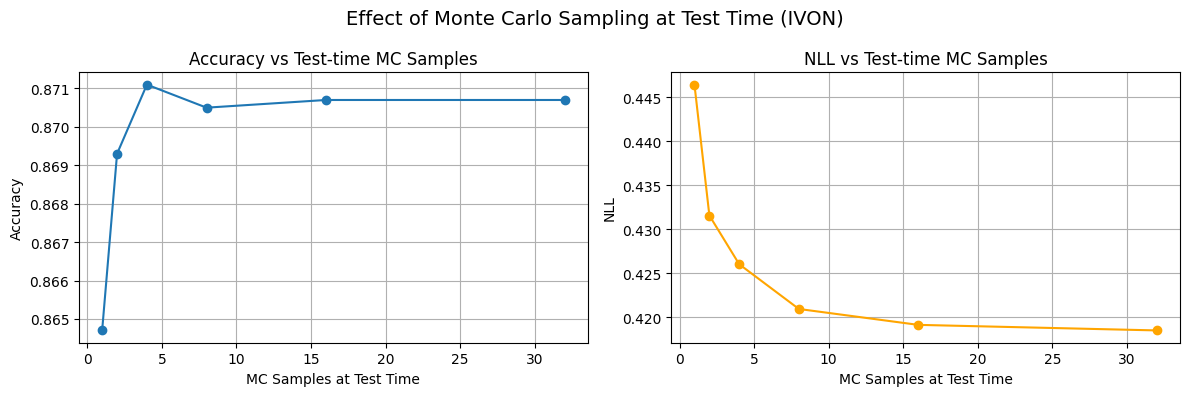

In [ ]:
# ============================================================
# Figure 1 — Test-time MC sweep
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_panel(
    axes[0], test_samples_list, accs_test,
    "Accuracy vs Test-time MC Samples",
    "MC Samples at Test Time",
    "Accuracy"
)

plot_panel(
    axes[1], test_samples_list, nlls_test,
    "NLL vs Test-time MC Samples",
    "MC Samples at Test Time",
    "NLL",
    color="orange"
)

plt.suptitle("Effect of Monte Carlo Sampling at Test Time (IVON)", fontsize=14)
plt.tight_layout()
plt.show()




In [ ]:
# --------------------------------------------------------------
# 4. Figure 4 — Bottom row: Varying train_samples
# --------------------------------------------------------------
# --------------------------------------------------------------
# Train-time sampling sweep WITHOUT retraining train_samples=1
# --------------------------------------------------------------

# 1. Evaluate the already-trained model (train_samples = 1)
metrics_1 = evaluate_all_metrics(
    model_ivon,
    optimizer_ivon,
    test_loader,
    device,
    test_samples=0   # evaluate @ mean
)

accs_train = [metrics_1["Top-1 Acc ↑"]]
nlls_train = [metrics_1["NLL ↓"]]
train_samples_list_done = [1]

print(f"train_samples=1 → Acc={accs_train[-1]:.4f}, NLL={nlls_train[-1]:.4f}")


train_samples=1 → Acc=0.8704, NLL=0.4317


In [12]:
# 2. Define the remaining training-sample values
train_samples_list_remaining = [2, 4, 8]

# 3. Train and evaluate ONLY the missing ones
for s in train_samples_list_remaining:

    print(f"\nTraining IVON with train_samples = {s} ...")
    model_s, opt_s = train_ivon(train_samples=s, epochs=150)

    # Evaluate using posterior mean
    metrics = evaluate_all_metrics(
        model_s,
        opt_s,
        test_loader,
        device,
        test_samples=0
    )

    accs_train.append(metrics["Top-1 Acc ↑"])
    nlls_train.append(metrics["NLL ↓"])
    train_samples_list_done.append(s)

    print(f"train_samples={s} → Acc={accs_train[-1]:.4f}, NLL={nlls_train[-1]:.4f}")

# 4. Build final DataFrame
df_train = pd.DataFrame({
    "Train Samples (MC)": train_samples_list_done,
    "Accuracy": accs_train,
    "NLL": nlls_train,
})

display(df_train)


Training IVON with train_samples = 8 ...
train_samples=8 → Acc=0.8842, NLL=0.3721


,Train Samples (MC),Accuracy,NLL
0,1,0.8704,0.431700
1,2,0.8769,0.392000
2,4,0.8837,0.397000
3,8,0.8842,0.372095


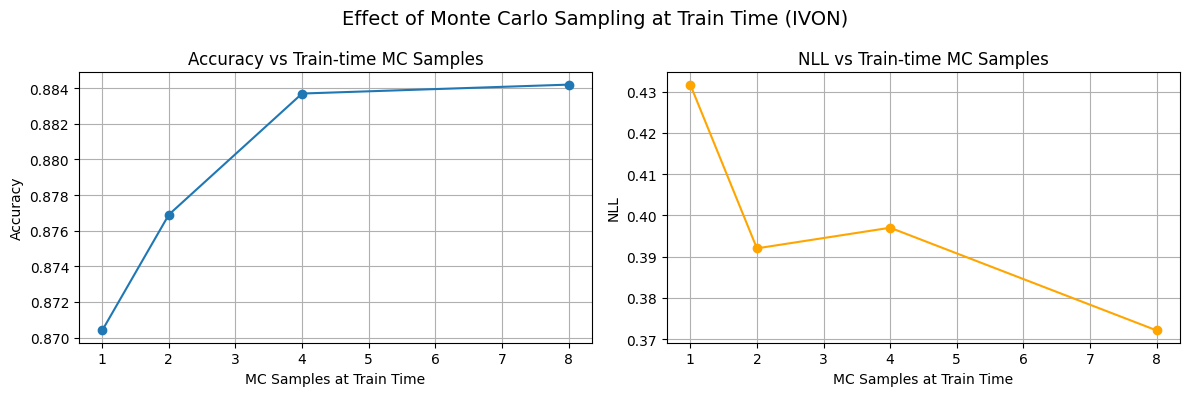

In [13]:
# ============================================================
# Figure — Train-time MC sweep
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_panel(
    axes[0], train_samples_list_done, accs_train,
    "Accuracy vs Train-time MC Samples",
    "MC Samples at Train Time",
    "Accuracy"
)

plot_panel(
    axes[1], train_samples_list_done, nlls_train,
    "NLL vs Train-time MC Samples",
    "MC Samples at Train Time",
    "NLL",
    color="orange"
)

plt.suptitle("Effect of Monte Carlo Sampling at Train Time (IVON)", fontsize=14)
plt.tight_layout()
plt.show()


## Out-of-Distribution and In-Between Uncertainty Evaluation
In the next cell, we evaluate the model on **SVHN**, which serves as an out-of-distribution dataset relative to CIFAR-10.
This reproduces the paper’s OOD uncertainty results—corresponding to **Figure 3(a)** and the detection metrics reported in **Table 3**.
Moreover, we are going to test **class exclusion**, where specific CIFAR-10 classes are withheld during training to further examine the model’s uncertainty under intentional distribution gaps.
Here we again use the same OOD uncertainty metrics to evaluate how effectively the model identifies excluded classes as uncertain.

Subtask: Load the SVHN test dataset and apply the same normalization as CIFAR-10, then create a PyTorch DataLoader for the SVHN test set to be used as an Out-of-Distribution dataset.

In [ ]:
transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std), # Re-using CIFAR-10 mean and std
])

# Load the SVHN test dataset
svhn_dataset = torchvision.datasets.SVHN(
    root='./data',
    split='test',
    transform=transform_svhn,
    download=True
)

# Create a DataLoader for the SVHN test dataset
svhn_loader = torch.utils.data.DataLoader(
    svhn_dataset,
    batch_size=50,
    shuffle=False
)

print("SVHN test dataset loaded and DataLoader created.")

100%|██████████| 64.3M/64.3M [00:16<00:00, 3.92MB/s]


SVHN test dataset loaded and DataLoader created.


### Class-Exclusion Experiment Pipeline

The following three code cells implement a full **class-exclusion uncertainty experiment** on CIFAR-10 using the IVON optimizer. First, we build custom datasets using `ExcludedClassDataset`, which filters out selected classes (e.g., *airplane* and *automobile*) from training while creating separate test sets for included and excluded classes. Second, we construct DataLoaders for these splits and train a ResNet-20 model **only on the remaining CIFAR-10 classes**, ensuring the excluded classes are completely unseen during training. Finally, we evaluate the trained model by computing predictive entropy via Monte Carlo sampling on three datasets—**included CIFAR-10 classes**, **excluded CIFAR-10 classes**, and **SVHN**—and generate uncertainty plots and OOD-style metrics to compare how the model behaves on seen, unseen, and external data.


In [ ]:
# Define CIFAR-10 class_names
cifar10_class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

# Create a custom PyTorch Dataset class called ExcludedClassDataset
class FilteredClassDataset(Dataset):
    def __init__(self, original_dataset, excluded_classes_by_name, return_excluded=False):
        self.original_dataset = original_dataset
        self.return_excluded = return_excluded

        # Build class-name → index mapping
        self.class_to_idx = {name: i for i, name in enumerate(cifar10_class_names)}
        self.excluded_class_indices = {self.class_to_idx[name] for name in excluded_classes_by_name}

        # Prefer using targets for speed
        if hasattr(original_dataset, "targets"):
            labels = original_dataset.targets
        else:
            # fallback (slow)
            labels = [original_dataset[i][1] for i in range(len(original_dataset))]

        # Filter indices
        self.filtered_indices = []
        included_labels = set()

        for i, label in enumerate(labels):
            is_excluded = label in self.excluded_class_indices

            if (is_excluded and return_excluded) or (not is_excluded and not return_excluded):
                self.filtered_indices.append(i)
                if not return_excluded:
                    included_labels.add(label)

        # Build label mapping for included classes
        self.label_mapping = None
        if not return_excluded:
            sorted_labels = sorted(included_labels)
            self.label_mapping = {old: new for new, old in enumerate(sorted_labels)}

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        original_idx = self.filtered_indices[idx]
        img, label = self.original_dataset[original_idx]

        if self.label_mapping:
            label = self.label_mapping[label]

        return img, label


In [ ]:
# ============================================================
# Part 1 — Create datasets for class exclusion setup
# ============================================================

# These classes will be removed from training,
# but they are still normal CIFAR-10 classes (NOT real OOD).
excluded_classes_for_ood = ['airplane', 'automobile']

print("Preparing datasets using ExcludedClassDataset...")
print(f"Excluded classes: {excluded_classes_for_ood}")
print("-" * 60)

# ------------------------------------------------------------
# Training set containing ONLY the included (non-excluded) classes
# ------------------------------------------------------------
cifar10_train_included = FilteredClassDataset(
    full_train_dataset,
    excluded_classes_by_name=excluded_classes_for_ood,
    return_excluded=False
)

print(f"[TRAIN INCLUDED] CIFAR-10 training data (excluded {', '.join(excluded_classes_for_ood)}): "
      f"{len(cifar10_train_included)} samples")

# ------------------------------------------------------------
# Test set containing ONLY the excluded classes
# (these are “class-OOD”, not true OOD)
# ------------------------------------------------------------
cifar10_test_excluded = FilteredClassDataset(
    test_dataset,
    excluded_classes_by_name=excluded_classes_for_ood,
    return_excluded=True
)

print(f"[TEST OOD] CIFAR-10 test data (only {', '.join(excluded_classes_for_ood)}): "
      f"{len(cifar10_test_excluded)} samples")

# ------------------------------------------------------------
# Test set containing ONLY the included (training) classes
# ------------------------------------------------------------
cifar10_test_included = FilteredClassDataset(
    test_dataset,
    excluded_classes_by_name=excluded_classes_for_ood,
    return_excluded=False
)

print(f"[TEST INCLUDED] CIFAR-10 test data (included classes only): "
      f"{len(cifar10_test_included)} samples")
print("-" * 60)


Preparing datasets using ExcludedClassDataset...
Excluded classes: ['airplane', 'automobile']
------------------------------------------------------------
[TRAIN INCLUDED] CIFAR-10 training data (excluded airplane, automobile): 40000 samples
[TEST OOD] CIFAR-10 test data (only airplane, automobile): 2000 samples
[TEST INCLUDED] CIFAR-10 test data (included classes only): 8000 samples
------------------------------------------------------------


In [ ]:
# ============================================================
# Part 2 — Create DataLoaders and train IVON
# ============================================================

batch_size = 50
print(f"Creating DataLoaders (batch size = {batch_size})...")

# Training loader (included classes)
cifar10_train_included_loader = DataLoader(
    cifar10_train_included,
    batch_size=batch_size,
    shuffle=True
)
print("✔ DataLoader for TRAIN INCLUDED classes created.")

# Test loader (excluded classes — class-OOD)
cifar10_test_excluded_loader = DataLoader(
    cifar10_test_excluded,
    batch_size=batch_size,
    shuffle=False
)
print("✔ DataLoader for TEST EXCLUDED (OOD) classes created.")

# Test loader (included classes — in-domain)
cifar10_test_included_loader = DataLoader(
    cifar10_test_included,
    batch_size=batch_size,
    shuffle=False
)
print("✔ DataLoader for TEST INCLUDED (normal test) classes created.")
print("-" * 60)


# Train IVON on included classes
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_ivon_excluded(model, optimizer, train_loader, device, epochs=10, train_samples=1):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            for _ in range(train_samples):
                with optimizer.sampled_params(train=True):
                    logits = model(X)
                    loss = F.cross_entropy(logits, y)
                    loss.backward()
            optimizer.step()
        print(f"IVON (excluded classes) Epoch done: {epoch+1}")

model_ivon_excluded = ResNet20().to(device)

optimizer_ivon_excluded = ivon.IVON(
    model_ivon_excluded.parameters(),
    lr=0.1,
    ess=len(cifar10_train_included)
)

train_ivon_excluded(
    model_ivon_excluded,
    optimizer_ivon_excluded,
    cifar10_train_included_loader,
    device=device,
    epochs=150
)


Creating DataLoaders (batch size = 50)...
✔ DataLoader for TRAIN INCLUDED classes created.
✔ DataLoader for TEST EXCLUDED (OOD) classes created.
✔ DataLoader for TEST INCLUDED (normal test) classes created.
------------------------------------------------------------
IVON (excluded classes) Epoch done: 1
IVON (excluded classes) Epoch done: 2
IVON (excluded classes) Epoch done: 3
IVON (excluded classes) Epoch done: 4
IVON (excluded classes) Epoch done: 5
IVON (excluded classes) Epoch done: 6
IVON (excluded classes) Epoch done: 7
IVON (excluded classes) Epoch done: 8
IVON (excluded classes) Epoch done: 9
IVON (excluded classes) Epoch done: 10
IVON (excluded classes) Epoch done: 11
IVON (excluded classes) Epoch done: 12
IVON (excluded classes) Epoch done: 13
IVON (excluded classes) Epoch done: 14
IVON (excluded classes) Epoch done: 15
IVON (excluded classes) Epoch done: 16
IVON (excluded classes) Epoch done: 17
IVON (excluded classes) Epoch done: 18
IVON (excluded classes) Epoch done: 19


In [ ]:
# ============================================================
# Train SGD
# ============================================================

def train_sgd(model, optimizer, train_loader, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

        print(f"SGD (excluded classes) Epoch done: {epoch+1}")


model_sgd = ResNet20().to(device)
optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.1)

train_sgd(model_sgd, optimizer_sgd, cifar10_train_included_loader, device=device, epochs=150)


SGD (excluded classes) Epoch done: 1
SGD (excluded classes) Epoch done: 2
SGD (excluded classes) Epoch done: 3
SGD (excluded classes) Epoch done: 4
SGD (excluded classes) Epoch done: 5
SGD (excluded classes) Epoch done: 6
SGD (excluded classes) Epoch done: 7
SGD (excluded classes) Epoch done: 8
SGD (excluded classes) Epoch done: 9
SGD (excluded classes) Epoch done: 10
SGD (excluded classes) Epoch done: 11
SGD (excluded classes) Epoch done: 12
SGD (excluded classes) Epoch done: 13
SGD (excluded classes) Epoch done: 14
SGD (excluded classes) Epoch done: 15
SGD (excluded classes) Epoch done: 16
SGD (excluded classes) Epoch done: 17
SGD (excluded classes) Epoch done: 18
SGD (excluded classes) Epoch done: 19
SGD (excluded classes) Epoch done: 20
SGD (excluded classes) Epoch done: 21
SGD (excluded classes) Epoch done: 22
SGD (excluded classes) Epoch done: 23
SGD (excluded classes) Epoch done: 24
SGD (excluded classes) Epoch done: 25
SGD (excluded classes) Epoch done: 26
SGD (excluded classes

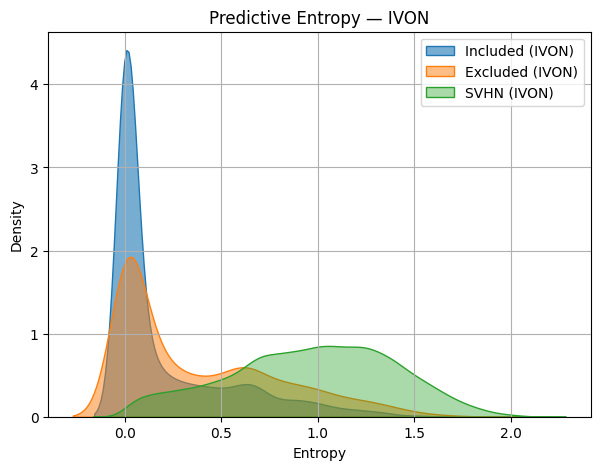

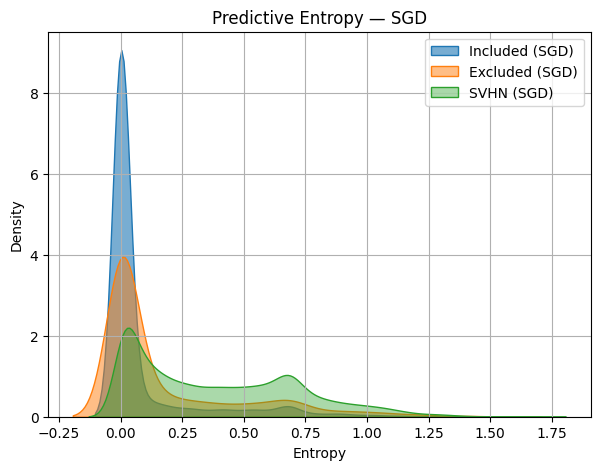

In [ ]:
# ==============================================================
# Part 3 — Predictive Entropy, KDE Plots, and Unified Metrics
# ==============================================================

# --------------------------------------------------------------
# a1. Predictive Entropy Functions
# --------------------------------------------------------------

# IVON entropy (uses optimizer.sampled_params)
def predictive_entropy(logits_mc):
    probs = logits_mc.softmax(dim=-1)
    entropy_per_sample = -(probs * (probs + 1e-12).log()).sum(dim=-1)  # [S, B]
    return entropy_per_sample.mean(dim=0).cpu().numpy()                # [B]


def get_entropy_ivon(model, optimizer, loader, mc_samples=5):
    model.eval()
    all_entropies = []

    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)

            logits_list = []
            for _ in range(mc_samples):
                with optimizer.sampled_params(train=False):
                    logits_list.append(model(X))

            logits_mc = torch.stack(logits_list, dim=0)   # [S, B, C]
            entropy = predictive_entropy(logits_mc)
            all_entropies.append(entropy)

    return np.concatenate(all_entropies)  # [N]


# SGD entropy (deterministic forward pass)
def get_entropy_sgd(model, loader):
    model.eval()
    all_entropies = []

    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)
            logits = model(X)
            probs = logits.softmax(dim=-1)
            entropy = -(probs * (probs + 1e-12).log()).sum(dim=-1)  # [B]
            all_entropies.append(entropy.cpu().numpy())

    return np.concatenate(all_entropies)


# --------------------------------------------------------------
# a2. Compute All Entropies (IVON & SGD)
# --------------------------------------------------------------

# ---- IVON ----
entropy_included_ivon = get_entropy_ivon(model_ivon_excluded, optimizer_ivon_excluded, cifar10_test_included_loader)
entropy_excluded_ivon = get_entropy_ivon(model_ivon_excluded, optimizer_ivon_excluded, cifar10_test_excluded_loader)
entropy_svhn_ivon     = get_entropy_ivon(model_ivon_excluded, optimizer_ivon_excluded, svhn_loader)

# ---- SGD ----
entropy_included_sgd = get_entropy_sgd(model_sgd, cifar10_test_included_loader)
entropy_excluded_sgd = get_entropy_sgd(model_sgd, cifar10_test_excluded_loader)
entropy_svhn_sgd     = get_entropy_sgd(model_sgd, svhn_loader)


# --------------------------------------------------------------
# a3. KDE Plots — One for IVON, One for SGD
# --------------------------------------------------------------

# ---- Plot IVON ----
plt.figure(figsize=(7,5))
sns.kdeplot(entropy_included_ivon, fill=True, label="Included (IVON)", alpha=0.6)
sns.kdeplot(entropy_excluded_ivon, fill=True, label="Excluded (IVON)", alpha=0.5)
sns.kdeplot(entropy_svhn_ivon,     fill=True, label="SVHN (IVON)", alpha=0.4)
plt.title("Predictive Entropy — IVON")
plt.xlabel("Entropy")
plt.legend()
plt.grid(True)
plt.show()


# ---- Plot SGD ----
plt.figure(figsize=(7,5))
sns.kdeplot(entropy_included_sgd, fill=True, label="Included (SGD)", alpha=0.6)
sns.kdeplot(entropy_excluded_sgd, fill=True, label="Excluded (SGD)", alpha=0.5)
sns.kdeplot(entropy_svhn_sgd,     fill=True, label="SVHN (SGD)", alpha=0.4)
plt.title("Predictive Entropy — SGD")
plt.xlabel("Entropy")
plt.legend()
plt.grid(True)
plt.show()


## OOD Detection Metrics

---

### **AUROC — Area Under the ROC Curve**
Measures how well the score separates ID vs. OOD samples.

$$
\text{AUROC} = \int_{0}^{1} \text{TPR}(\text{FPR}) \, d\text{FPR}
$$

Equivalent interpretation:

$$
\text{AUROC} = \Pr\big(s_{\text{ood}} > s_{\text{in}}\big)
$$

Higher is better.

---

### **FPR@95 — False Positive Rate at 95% TPR**
False positive rate when the true positive rate for OOD detection is 95%.

Find threshold $ f^* $ such that:

$$
\text{TPR}(f^*) \approx 0.95
$$

Then report:

$$
\text{FPR@95} = \text{FPR}(f^*)
$$

Lower is better.

---

### **Detection Error**
Minimum classification error assuming equal priors for ID and OOD.

$$
\text{Detection Error}
= \min_f \left[ 0.5 \cdot \text{FPR}(f) + 0.5 \cdot \text{FNR}(f) \right]
$$

where

$$
\text{FNR}(f) = 1 - \text{TPR}(f)
$$

Lower is better.

---

### **AUPR-In — Area Under Precision–Recall (ID as Positive Class)**
Precision–Recall AUC with **ID = positive**.

$$
\text{AUPR-In} = \int_0^1 \text{Precision}_{\text{in}}(r) \, dr
$$

Higher means better ID recognition.

---

### **AUPR-Out — Area Under Precision–Recall (OOD as Positive Class)**
Precision–Recall AUC with **OOD = positive**.

$$
\text{AUPR-Out} = \int_0^1 \text{Precision}_{\text{out}}(r) \, dr
$$

Higher means better OOD detection.

---


In [ ]:
# --------------------------------------------------------------
# b1. Metrics
# --------------------------------------------------------------
def compute_fpr95(scores_in, scores_ood):
    labels = np.concatenate([np.zeros_like(scores_in), np.ones_like(scores_ood)])
    scores = np.concatenate([scores_in, scores_ood])
    fprs, tprs, _ = roc_curve(labels, scores)
    idx = np.argmin(np.abs(tprs - 95/100))
    return fprs[idx]


def compute_detection_error(scores_in, scores_ood):
    labels = np.concatenate([np.zeros_like(scores_in), np.ones_like(scores_ood)])
    scores = np.concatenate([scores_in, scores_ood])
    fprs, tprs, _ = roc_curve(labels, scores)
    fnrs = 1 - tprs
    return np.min(0.5 * (fnrs + fprs))


def compute_aupr(scores_in, scores_ood):
    labels = np.concatenate([np.zeros_like(scores_in), np.ones_like(scores_ood)])
    scores = np.concatenate([scores_in, scores_ood])

    # AUPR-In (IN is positive class)
    prec_in, rec_in, _ = precision_recall_curve(1 - labels, -scores)
    aupr_in = auc(rec_in, prec_in)

    # AUPR-Out (OOD is positive class)
    prec_out, rec_out, _ = precision_recall_curve(labels, scores)
    aupr_out = auc(rec_out, prec_out)

    return aupr_in, aupr_out



# --------------------------------------------------------------
# b2. Metrics (AUROC, FPR@95, Detection Error, AUPR)
# --------------------------------------------------------------

def collect_metrics(ent_in, ent_ood):
    labels = np.concatenate([np.zeros_like(ent_in), np.ones_like(ent_ood)])
    scores = np.concatenate([ent_in, ent_ood])

    auroc = roc_auc_score(labels, scores)
    fpr95 = compute_fpr95(ent_in, ent_ood)
    det_err = compute_detection_error(ent_in, ent_ood)
    aupr_in, aupr_out = compute_aupr(ent_in, ent_ood)

    return auroc, fpr95, det_err, aupr_in, aupr_out



# --------------------------------------------------------------
# b3. Unified Comparison Table — IVON vs SGD
# --------------------------------------------------------------

rows = []

datasets = {
    "Excluded CIFAR-10": (
        entropy_excluded_ivon, entropy_excluded_sgd
    ),
    "SVHN": (
        entropy_svhn_ivon, entropy_svhn_sgd
    )
}

for name, (ent_ood_ivon, ent_ood_sgd) in datasets.items():

    metrics_ivon = collect_metrics(entropy_included_ivon, ent_ood_ivon)
    metrics_sgd  = collect_metrics(entropy_included_sgd,  ent_ood_sgd)

    rows.append({
        "Dataset": name,
        "IVON_AUROC":     metrics_ivon[0],
        "SGD_AUROC":      metrics_sgd[0],
        "IVON_FPR95":     metrics_ivon[1],
        "SGD_FPR95":      metrics_sgd[1],
        "IVON_DetErr":    metrics_ivon[2],
        "SGD_DetErr":     metrics_sgd[2],
        "IVON_AUPR-In":   metrics_ivon[3],
        "SGD_AUPR-In":    metrics_sgd[3],
        "IVON_AUPR-Out":  metrics_ivon[4],
        "SGD_AUPR-Out":   metrics_sgd[4],
    })

df_compare = pd.DataFrame(rows).set_index("Dataset")

print("========== UNIFIED OOD METRICS TABLE (IVON vs SGD) ==========")
display(df_compare.style.format("{:.4f}"))


========== UNIFIED OOD METRICS TABLE (IVON vs SGD) ==========


,IVON_AUROC,SGD_AUROC,IVON_FPR95,SGD_FPR95,IVON_DetErr,SGD_DetErr,IVON_AUPR-In,SGD_AUPR-In,IVON_AUPR-Out,SGD_AUPR-Out
Dataset,,,,,,,,,,
Excluded CIFAR-10,0.6377,0.6723,0.8842,0.8179,0.3921,0.3652,0.8649,0.8878,0.3054,0.3144
SVHN,0.9179,0.8739,0.3018,0.3151,0.1659,0.1796,0.8493,0.8158,0.9677,0.9360
